In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = "/content/drive/MyDrive/Datasets"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter
from sklearn.model_selection import KFold


In [ ]:
import cv2

# Load the image
img = cv2.imread("/content/drive/MyDrive/Datasets/PCB_DATASET/images/Missing_hole/01_missing_hole_01.jpg")

# Get image size
height, width, channels = img.shape

print(f"Width: {width}, Height: {height}, Channels: {channels}")


Width: 3034, Height: 1586, Channels: 3


In [ ]:
import os

dataset_dir = os.path.join(root_dir, 'PCB_DATASET')

for root, dirs, files in os.walk(dataset_dir):
    for name in dirs:
        print(name)  # Print only the folder names


Annotations
PCB_USED
images
rotation
images_resized
output
ImageSets
.ipynb_checkpoints
final_annotations
Missing_hole
Mouse_bite
Open_circuit
Short
Spur
Spurious_copper
Missing_hole
Mouse_bite
Open_circuit
Short
Spur
Spurious_copper
Missing_hole_rotation
Mouse_bite_rotation
Open_circuit_rotation
Short_rotation
Spur_rotation
Spurious_copper_rotation
Main
Missing_hole
Mouse_bite
Open_circuit
Short
Spur
Spurious_copper


In [ ]:
!git clone https://github.com/isabek/XmlToTxt.git

Cloning into 'XmlToTxt'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 108 (delta 23), reused 19 (delta 17), pack-reused 76 (from 1)
Receiving objects: 100% (108/108), 17.58 KiB | 1.95 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [ ]:
%cd XmlToTxt
!pip install -r requirements.txt

/content/XmlToTxt


In [ ]:
def count_files_in_folder(folder_path):
    # Get list of all files in the folder
    files = os.listdir(folder_path)

    # Count the number of files
    num_files = len(files)

    return num_files

In [ ]:
subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

images_dir = os.path.join(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')

Missing_hole    	            115 images 	            115 annotations
Mouse_bite      	            115 images 	            115 annotations
Open_circuit    	            116 images 	            116 annotations
Short           	            116 images 	            116 annotations
Spur            	            115 images 	            115 annotations
Spurious_copper 	            116 images 	            116 annotations


In [ ]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    data = []

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return data

In [ ]:
# List to store parsed data from all XML files
all_data = []

# Recursively traverse subdirectories
for root, dirs, files in os.walk(annot_dir):
    for name in files:
        if name.endswith('.xml'):
            xml_path = os.path.join(root, name)
            all_data.extend(parse_xml(xml_path))

In [ ]:
# Create DataFrame from the parsed data
annot_df = pd.DataFrame(all_data)
annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_missing_hole_05.jpg,3034,1586,missing_hole,804,298,860,365
1,01_missing_hole_05.jpg,3034,1586,missing_hole,279,294,353,374
2,01_missing_hole_05.jpg,3034,1586,missing_hole,1068,1051,1110,1107
3,01_missing_hole_05.jpg,3034,1586,missing_hole,1613,392,1677,460
4,01_missing_hole_04.jpg,3034,1586,missing_hole,1619,225,1673,278


In [ ]:
def get_subfolder(image_name):
    if 'missing' in image_name.split('_'):
        return 'Missing_hole'
    if 'mouse' in image_name.split('_'):
        return'Mouse_bite'
    if 'open' in image_name.split('_'):
        return 'Open_circuit'
    if 'short' in image_name.split('_'):
        return 'Short'
    if 'spur' in image_name.split('_'):
        return 'Spur'
    if 'spurious' in image_name.split('_'):
        return 'Spurious_copper'

In [ ]:
def visualize_annotations(image_name, images_dir, annot_df, is_subfolder=False):
    # Construct path for image
    if is_subfolder:
        image_path = os.path.join(images_dir, get_subfolder(image_name), image_name)
        print(image_path)
    else:
        image_path = os.path.join(images_dir, image_name)

    # Read image
    image = cv2.imread(image_path)

    # Filter annotations for the current image
    annotations = annot_df[annot_df['filename'] == image_name]

    # Draw bounding boxes on the image
    for _, annot in annotations.iterrows():
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']
        class_label = annot['class']

        # Check if confidence column exists
        confidence = annot.get('confidence')
        if confidence is not None:
            class_label += f" ({confidence:.2f})"

        color = (255, 255, 255)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 3)

        # Add background to the text
        text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)[0]
        cv2.rectangle(image, (xmin, ymin - text_size[1] - 5),
                             (xmin + text_size[0], ymin - 1), color, -1)

        # Add text
        cv2.putText(image, class_label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

    # Convert BGR image to RGB (Matplotlib expects RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with annotations
    plt.figure(figsize=(18, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Annotations')
    plt.text(10, image_rgb.shape[0] + 100, f'Image: {image_name}',
             color='black', fontsize=11, ha='left')
    plt.show()

    return image


/content/drive/MyDrive/Datasets/PCB_DATASET/images/Spurious_copper/05_spurious_copper_06.jpg


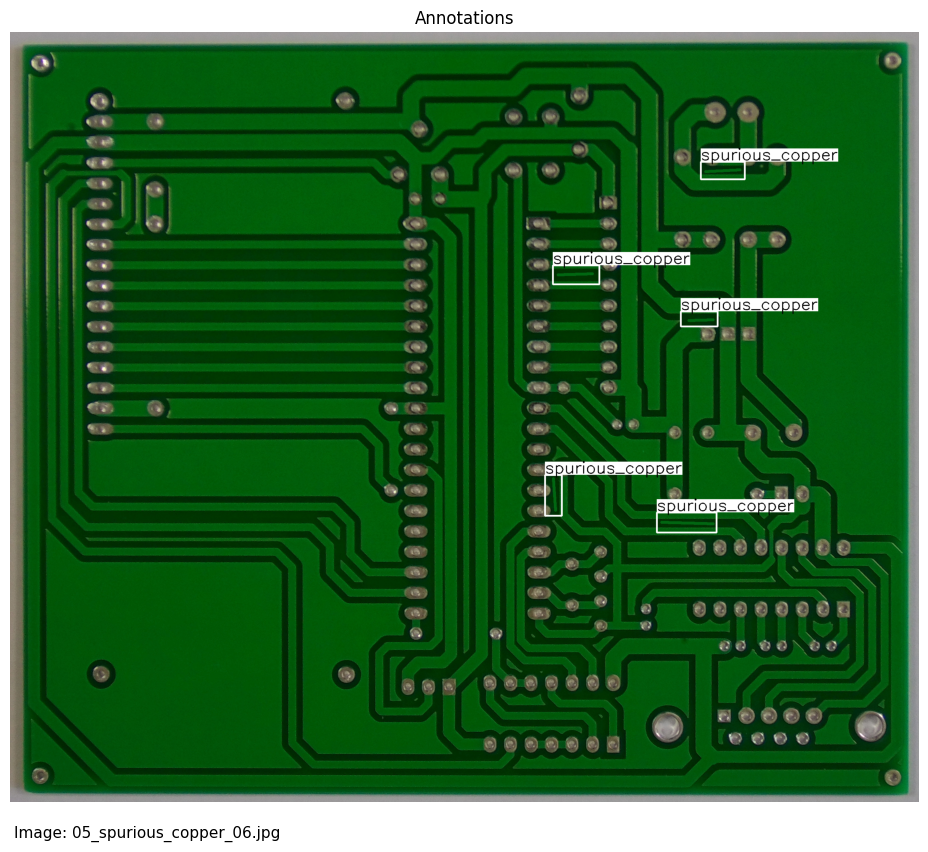

In [ ]:
image_name = '05_spurious_copper_06.jpg'
visualize_annotations(image_name, images_dir, annot_df, is_subfolder=True);

In [ ]:
def resize_images(input_dir, output_dir, target_size=(640, 640)):
    # Check if the output directory exists
    if os.path.exists(output_dir):
        print(f"Directory already exists: {output_dir}")
    else:
        os.makedirs(output_dir, exist_ok=True)
        print(f"Created directory: {output_dir}")

        # Traverse through the subfolders in the input folder
        for root, _, files in os.walk(input_dir):
            for file in files:
                # Check if the file is an image
                if file.lower().endswith('.jpg'):
                    # Read the image
                    image_path = os.path.join(root, file)
                    image = cv2.imread(image_path)

                    # Resize the image
                    resized_image = cv2.resize(image, target_size)

                    # Save the resized image to the output folder
                    output_path = os.path.join(output_dir, file)
                    cv2.imwrite(output_path, resized_image)
                    print(f"Resized and saved: {output_path}")

resized_img_dir = os.path.join(dataset_dir, 'images_resized')
resize_images(images_dir, resized_img_dir)

In [ ]:
def resize_annotations(annot_df, target_size=(640, 640)):
    all_data = []

    # Iterate through the annotation DataFrame
    for index, row in annot_df.iterrows():

        # Resize the bounding box coordinates
        width_ratio = target_size[0] / row['width']
        height_ratio = target_size[1] / row['height']

        resized_xmin = int(row['xmin'] * width_ratio)
        resized_ymin = int(row['ymin'] * height_ratio)
        resized_xmax = int(row['xmax'] * width_ratio)
        resized_ymax = int(row['ymax'] * height_ratio)

        # Update the all data list with resized annotations
        all_data.append({
            'filename': row['filename'],
            'width': target_size[0],
            'height': target_size[1],
            'class': row['class'],
            'xmin': resized_xmin,
            'ymin': resized_ymin,
            'xmax': resized_xmax,
            'ymax': resized_ymax
        })

    annot_df_resized = pd.DataFrame(all_data)
    return annot_df_resized

annot_df_resized = resize_annotations(annot_df)
annot_df_resized.head()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import os

def split_and_move_data(df, image_folder, output_folder, test_size=0.2, random_state=42):
    # Split the data
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['class'])

    # Save CSV files
    os.makedirs(output_folder, exist_ok=True)
    train_csv_path = os.path.join(output_folder, 'train_annotations.csv')
    test_csv_path = os.path.join(output_folder, 'test_annotations.csv')
    train_df.to_csv(train_csv_path, index=False)
    test_df.to_csv(test_csv_path, index=False)

    print(f"Saved training data to {train_csv_path}")
    print(f"Saved testing data to {test_csv_path}")

    # Function to move images
    def move_images(df, dest_folder):
        os.makedirs(dest_folder, exist_ok=True)
        for _, row in df.iterrows():
            img_path = os.path.join(image_folder, row['filename'])
            dest_path = os.path.join(dest_folder, row['filename'])
            if os.path.exists(img_path):
                shutil.copy(img_path, dest_path)
            else:
                print(f"Warning: {img_path} not found.")

    # Move images to corresponding folders
    move_images(train_df, os.path.join(output_folder, 'train_images'))
    move_images(test_df, os.path.join(output_folder, 'test_images'))

    print("Data splitting and image moving completed.")

# Example usage (assuming df is already defined)
split_and_move_data(df, 'images', 'output')


In [ ]:
output_dir = os.path.join(dataset_dir, 'output')
if os.path.exists(output_dir):
    print(f"Directory already exists: {output_dir}")
else:
    os.makedirs(output_dir, exist_ok=True)
    print(f"Created directory: {output_dir}")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import os

def split_and_move_data(csv_path, image_folder, output_folder, test_size=0.2, random_state=42):
    # Load the annotations
    df = pd.read_csv(csv_path)

    # Split the data
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['class'])

    # Save CSV files
    os.makedirs(output_folder, exist_ok=True)
    train_csv_path = os.path.join(output_folder, 'train_annotations.csv')
    test_csv_path = os.path.join(output_folder, 'test_annotations.csv')
    train_df.to_csv(train_csv_path, index=False)
    test_df.to_csv(test_csv_path, index=False)

    print(f"Saved training data to {train_csv_path}")
    print(f"Saved testing data to {test_csv_path}")

    # Function to move images
    def move_images(df, dest_folder):
        os.makedirs(dest_folder, exist_ok=True)
        for _, row in df.iterrows():
            img_path = os.path.join(image_folder, row['filename'])
            dest_path = os.path.join(dest_folder, row['filename'])
            if os.path.exists(img_path):
                shutil.copy(img_path, dest_path)
            else:
                print(f"Warning: {img_path} not found.")

    # Move images to corresponding folders
    move_images(train_df, os.path.join(output_folder, 'train_images'))
    move_images(test_df, os.path.join(output_folder, 'test_images'))

    print("Data splitting and image moving completed.")

# Example usage
split_and_move_data('annotations.csv', 'images', 'output')


In [ ]:
annot_df_resized.to_json("annotations.json", orient="records", indent=4)


In [ ]:
# Load Pascal VOC JSON
import json
with open("annotations.json", "r") as f:
    data = json.load(f)

# Shuffle dataset for randomness
random.shuffle(data)

# Define split ratio (80% train, 20% test)
split_ratio = 0.8
train_size = int(len(data) * split_ratio)

# Split dataset
train_data = data[:train_size]
test_data = data[train_size:]

# Save train and test datasets
train_json_file = "/content/drive/MyDrive/Datasets/PCB_DATASET/train.json"
test_json_file = "/content/drive/MyDrive/Datasets/PCB_DATASET/test.json"

with open(train_json_file, "w") as f:
    json.dump(train_data, f, indent=4)

with open(test_json_file, "w") as f:
    json.dump(test_data, f, indent=4)

print(f"✅ Train dataset saved: {train_json_file}")
print(f"✅ Test dataset saved: {test_json_file}")


In [ ]:
import os
import pandas as pd
from lxml import etree

# Paths
csv_path = "/content/drive/MyDrive/Datasets/PCB_DATASET/resized_annotations.csv"
output_dir = "/content/drive/MyDrive/Datasets/PCB_DATASET/final_annotations"
os.makedirs(output_dir, exist_ok=True)

def create_xml(row):
    # Create root element
    annotation = etree.Element('annotation')

    # Filename
    etree.SubElement(annotation, 'filename').text = row['filename']

    # Image size
    size = etree.SubElement(annotation, 'size')
    etree.SubElement(size, 'width').text = str(row['width'])
    etree.SubElement(size, 'height').text = str(row['height'])
    etree.SubElement(size, 'depth').text = '3'  # Assuming RGB images

    # Object details
    obj = etree.SubElement(annotation, 'object')
    etree.SubElement(obj, 'name').text = row['class']
    etree.SubElement(obj, 'pose').text = 'Unspecified'
    etree.SubElement(obj, 'truncated').text = '0'
    etree.SubElement(obj, 'difficult').text = '0'

    # Bounding Box
    bbox = etree.SubElement(obj, 'bndbox')
    etree.SubElement(bbox, 'xmin').text = str(row['xmin'])
    etree.SubElement(bbox, 'ymin').text = str(row['ymin'])
    etree.SubElement(bbox, 'xmax').text = str(row['xmax'])
    etree.SubElement(bbox, 'ymax').text = str(row['ymax'])

    # Convert to string
    xml_str = etree.tostring(annotation, pretty_print=True, encoding="UTF-8").decode()

    # Create subfolder for the class (First letter capitalized)
    class_folder = os.path.join(output_dir, row['class'].capitalize())
    os.makedirs(class_folder, exist_ok=True)

    # Save XML file
    xml_filename = os.path.splitext(row['filename'])[0] + ".xml"
    xml_path = os.path.join(class_folder, xml_filename)
    with open(xml_path, 'w') as f:
        f.write(xml_str)
    print(f"✅ XML saved to: {xml_path}")

def convert_csv_to_xml(csv_path):
    df = pd.read_csv(csv_path)

    for _, row in df.iterrows():
        create_xml(row)

    print("✅ Conversion completed!")

# Run conversion
convert_csv_to_xml(csv_path)
